In [1]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

####  distance_matrix: An array of distances between locations on meters.
#### num_locations: The number of locations.
#### num_vehicles: The number of vehicles in the fleet.
#### depot: The index of the depot, the location where all vehicles start and end their routes.

In [30]:
points = [[3, 2], [5, 2], [7, 5]]

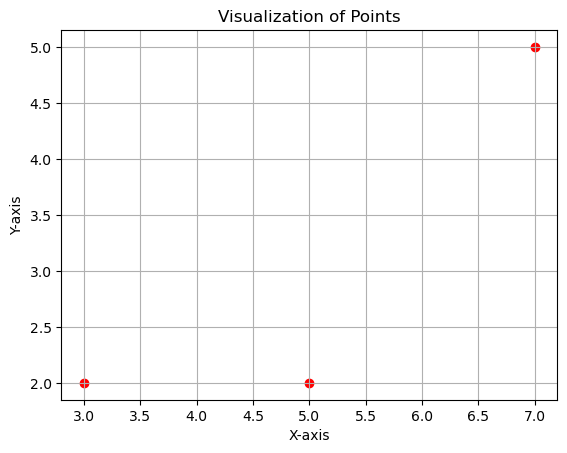

In [31]:
import matplotlib.pyplot as plt

points = [[3, 2], [5, 2], [7, 5]]

# Extract x and y coordinates
x_coordinates = [point[0] for point in points]
y_coordinates = [point[1] for point in points]

# Plot the points
plt.scatter(x_coordinates, y_coordinates, color='red', marker='o')

# Add labels and title
plt.title('Visualization of Points')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)
# Show the plot
plt.show()


In [78]:
def manhattan_distance(point1, point2):
    return abs(point1[0] - point2[0]) + abs(point1[1] - point2[1])

def creating_matrix(points):
    # Inicjalizacja macierzy odległości zerami
    distance_matrix = [[0 for _ in range(len(points))] for _ in range(len(points))]

    # Wypełnianie macierzy odległości
    for i in range(len(points)):
        for j in range(len(points)):
            distance_matrix[i][j] = manhattan_distance(points[i], points[j])
    return distance_matrix

### start for paper

In [16]:
matrix = [[0.0, 0.5903636317721634, 0.683673943665646, 0.44011235595489956, 0.18263436900301927, 0.03517215283597537, 0.2647347985681034, 0.3928112694523105, 0.16163491238906158, 0.5909685491463614, 0.4568542468557505], [0.5903636317721634, 0.0, 0.25612732176293496, 0.19109930874428313, 0.4617991336650459, 0.567653558826718, 0.6109682286817637, 0.36914382113648647, 0.48965997942205713, 0.17475843592283455, 1.0413789629479722], [0.683673943665646, 0.25612732176293496, 0.0, 0.25628507489994234, 0.5117113645946397, 0.6524803229828201, 0.7878941919909195, 0.5903234988624358, 0.5391476483236425, 0.10595448724107487, 1.0931341451644412], [0.44011235595489956, 0.19109930874428313, 0.25628507489994234, 0.0, 0.2857642243880516, 0.4118573440430331, 0.5328673370839396, 0.3616696372860891, 0.3143336076371871, 0.15442986762597377, 0.8748413412190906], [0.18263436900301927, 0.4617991336650459, 0.5117113645946397, 0.2857642243880516, 0.0, 0.14811057402679165, 0.39001296416256515, 0.3921395457987575, 0.028578343718642082, 0.4264010520303294, 0.5895933894750109], [0.03517215283597537, 0.567653558826718, 0.6524803229828201, 0.4118573440430331, 0.14811057402679165, 0.0, 0.2886587153494256, 0.3920845377209263, 0.12654378252450532, 0.5612643060737154, 0.47507184753266174], [0.2647347985681034, 0.6109682286817637, 0.7878941919909195, 0.5328673370839396, 0.39001296416256515, 0.2886587153494256, 0.0, 0.2728926243954447, 0.38384919679619406, 0.6830271244112902, 0.6030675712446354], [0.3928112694523105, 0.36914382113648647, 0.5903234988624358, 0.3616696372860891, 0.3921395457987575, 0.3920845377209263, 0.2728926243954447, 0.0, 0.40562258337008805, 0.48569384383986897, 0.8287112386056509], [0.16163491238906158, 0.48965997942205713, 0.5391476483236425, 0.3143336076371871, 0.028578343718642082, 0.12654378252450532, 0.38384919679619406, 0.40562258337008805, 0.0, 0.45465091417374365, 0.5610481891526209], [0.5909685491463614, 0.17475843592283455, 0.10595448724107487, 0.15442986762597377, 0.4264010520303294, 0.5612643060737154, 0.6830271244112902, 0.48569384383986897, 0.45465091417374365, 0.0, 1.0145041935103885], [0.4568542468557505, 1.0413789629479722, 1.0931341451644412, 0.8748413412190906, 0.5895933894750109, 0.47507184753266174, 0.6030675712446354, 0.8287112386056509, 0.5610481891526209, 1.0145041935103885, 0.0]]

In [17]:
len(matrix)

11

In [18]:
def float_to_int(z):
    for i, x in enumerate(z):
        for ii, y in enumerate(x):
            
            z[i][ii] = int(y *100)
    return z


In [19]:
matrix_dist = float_to_int(matrix)
matrix_dist

[[0, 59, 68, 44, 18, 3, 26, 39, 16, 59, 45],
 [59, 0, 25, 19, 46, 56, 61, 36, 48, 17, 104],
 [68, 25, 0, 25, 51, 65, 78, 59, 53, 10, 109],
 [44, 19, 25, 0, 28, 41, 53, 36, 31, 15, 87],
 [18, 46, 51, 28, 0, 14, 39, 39, 2, 42, 58],
 [3, 56, 65, 41, 14, 0, 28, 39, 12, 56, 47],
 [26, 61, 78, 53, 39, 28, 0, 27, 38, 68, 60],
 [39, 36, 59, 36, 39, 39, 27, 0, 40, 48, 82],
 [16, 48, 53, 31, 2, 12, 38, 40, 0, 45, 56],
 [59, 17, 10, 15, 42, 56, 68, 48, 45, 0, 101],
 [45, 104, 109, 87, 58, 47, 60, 82, 56, 101, 0]]

In [30]:
"""Capacited Vehicles Routing Problem (CVRP)."""
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data["distance_matrix"] =  matrix_dist
    data["demands"] = [0, 7, 2, 1, 2, 9, 9, 4, 9, 8, 4]
    data["vehicle_capacities"] = [20, 20, 20, 20]
    data["num_vehicles"] = 4
    data["depot"] = 0
    return data

In [31]:
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")
    total_distance = 0
    total_load = 0
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        plan_output = f"Route for vehicle {vehicle_id}:\n"
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data["demands"][node_index]
            plan_output += f" {node_index} Load({route_load}) -> "
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id
            )
        plan_output += f" {manager.IndexToNode(index)} Load({route_load})\n"
        plan_output += f"Distance of the route: {route_distance}m\n"
        plan_output += f"Load of the route: {route_load}\n"
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
    print(f"Total distance of all routes: {total_distance}m")
    print(f"Total load of all routes: {total_load}")


In [32]:
def main():
    """Solve the CVRP problem."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(data["distance_matrix"]), data["num_vehicles"], data["depot"]
    )

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Capacity constraint.
    def demand_callback(from_index):
        """Returns the demand of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = manager.IndexToNode(from_index)
        return data["demands"][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data["vehicle_capacities"],  # vehicle maximum capacities
        True,  # start cumul to zero
        "Capacity",
    )

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    )
    search_parameters.time_limit.FromSeconds(1)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(data, manager, routing, solution)


In [33]:
main()

Objective: 357
Route for vehicle 0:
 0 Load(0) ->  0 Load(0)
Distance of the route: 0m
Load of the route: 0

Route for vehicle 1:
 0 Load(0) ->  4 Load(2) ->  3 Load(3) ->  9 Load(11) ->  2 Load(13) ->  1 Load(20) ->  0 Load(20)
Distance of the route: 155m
Load of the route: 20

Route for vehicle 2:
 0 Load(0) ->  7 Load(4) ->  6 Load(13) ->  10 Load(17) ->  0 Load(17)
Distance of the route: 171m
Load of the route: 17

Route for vehicle 3:
 0 Load(0) ->  5 Load(9) ->  8 Load(18) ->  0 Load(18)
Distance of the route: 31m
Load of the route: 18

Total distance of all routes: 357m
Total load of all routes: 55


In [ ]:
[[0, 4, 7, 9, 3, 0], [0, 5, 2, 8, 0], [0, 10, 1, 6, 0], [0, 0]]

### time limit for searching

In [20]:
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.time_limit.seconds = 60

In [29]:
"""Capacited Vehicles Routing Problem (CVRP)."""

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data["distance_matrix"] = [[0, 42, 30, 63, 27, 53, 57, 79, 62, 41, 7],
 [42, 0, 16, 39, 30, 11, 42, 50, 30, 46, 37],
 [30, 16, 0, 36, 13, 28, 33, 51, 46, 49, 27],
 [63, 39, 36, 0, 36, 42, 12, 16, 66, 83, 63],
 [27, 30, 13, 36, 0, 41, 29, 53, 59, 57, 28],
 [53, 11, 28, 42, 41, 0, 48, 50, 23, 50, 47],
 [57, 42, 33, 12, 29, 48, 0, 27, 71, 83, 58],
 [79, 50, 51, 16, 53, 50, 27, 0, 73, 96, 78],
 [62, 30, 46, 66, 59, 23, 71, 73, 0, 41, 55],
 [41, 46, 49, 83, 57, 50, 83, 96, 41, 0, 34],
 [7, 37, 27, 63, 28, 47, 58, 78, 55, 34, 0]],
    
    data["demands"] = [0, 4, 3, 1, 5, 3, 5, 2, 8, 9, 3]
    data["vehicle_capacities"] = [20, 20, 20, 20]
    data["num_vehicles"] = 4
    data["depot"] = 0
    return data


def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")
    total_distance = 0
    total_load = 0
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        plan_output = f"Route for vehicle {vehicle_id}:\n"
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data["demands"][node_index]
            plan_output += f" {node_index} Load({route_load}) -> "
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id
            )
        plan_output += f" {manager.IndexToNode(index)} Load({route_load})\n"
        plan_output += f"Distance of the route: {route_distance}m\n"
        plan_output += f"Load of the route: {route_load}\n"
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
    print(f"Total distance of all routes: {total_distance}m")
    print(f"Total load of all routes: {total_load}")


def main():
    """Solve the CVRP problem."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(data["distance_matrix"]), data["num_vehicles"], data["depot"]
    )

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Capacity constraint.
    def demand_callback(from_index):
        """Returns the demand of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = manager.IndexToNode(from_index)
        return data["demands"][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data["vehicle_capacities"],  # vehicle maximum capacities
        True,  # start cumul to zero
        "Capacity",
    )

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    )
    search_parameters.time_limit.FromSeconds(1)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(data, manager, routing, solution)


if __name__ == "__main__":
    main()

Objective: 0
Route for vehicle 0:
 0 Load(0) ->  0 Load(0)
Distance of the route: 0m
Load of the route: 0

Route for vehicle 1:
 0 Load(0) ->  0 Load(0)
Distance of the route: 0m
Load of the route: 0

Route for vehicle 2:
 0 Load(0) ->  0 Load(0)
Distance of the route: 0m
Load of the route: 0

Route for vehicle 3:
 0 Load(0) ->  0 Load(0)
Distance of the route: 0m
Load of the route: 0

Total distance of all routes: 0m
Total load of all routes: 0
